In [1]:
import h5py # store big data
import scipy.io as io # scipy input and output
import PIL.Image as Image # read imagem, image processing
import numpy as np
import os
import glob # process the path used in unix
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter #gaussian covolution 
import scipy
import json
from matplotlib import cm as CM #color map
from image import *
from model import CSRNet
import torch
import os.path
%matplotlib inline

In [2]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt): #input the phote size array where one denotes the location of the people, 0 otherwise 
    print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])) # np.nonzero(gt) return a tuple of two array, the first one is the row index of non zero
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize) # construct the kdtree
    # query kdtree
    distances, locations = tree.query(pts, k=4) # get the four nearest points

    print('generate density...') 
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)# pt2d onnly has one people per loop
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1 #Q1: why ignore the nearest point
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point Q2:why do this when there is only one people
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print('done.')
    return density

In [3]:
#set the root to the Shanghai dataset you download
root = r'./shanghai/'

In [4]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,r'part_A_final/train_data','images')
part_A_test = os.path.join(root,r'part_A_final/test_data','images')
#part_B_train = os.path.join(root,'part_B_final/train_data','images')
#part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [5]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [6]:
img_path = img_paths[0]
mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_')) #mat is microsoft access table

In [7]:
mat['image_info'][0,0][0,0][0] # my guess is that this is the location of the people
img = plt.imread(img_paths[0])

In [8]:
mat['image_info'][0,0][0,0][0]

array([[  35.35696304,  501.34441558],
       [  48.65566434,  465.54021978],
       [  60.4199001 ,  497.25250749],
       [  19.50081918,  469.12063936],
       [   6.71360639,  460.42533467],
       [  34.84547453,  440.47728272],
       [  58.88543457,  398.53522478],
       [  73.7186014 ,  431.27048951],
       [  89.57474525,  474.23552448],
       [  65.0232967 ,  474.74701299],
       [ 133.05126873,  456.84491508],
       [ 107.98833167,  457.3564036 ],
       [ 121.28703297,  475.76999001],
       [ 141.74657343,  505.43632368],
       [ 169.36695305,  502.36739261],
       [ 172.94737263,  450.19556444],
       [ 192.38393606,  469.63212787],
       [ 234.07024975,  524.87288711],
       [ 246.34597403,  481.90785215],
       [ 270.89742258,  455.31044955],
       [ 244.30001998,  420.52923077],
       [ 304.65566434,  539.19456543],
       [ 323.06925075,  509.52823177],
       [ 379.33298701,  533.0567033 ],
       [ 452.98733267,  645.58417582],
       [ 488.79152847,  5

In [9]:
img.shape

(683, 1024, 3)

In [9]:
for img_path in img_paths:
    if os.path.isfile(img_path.replace('.jpg','.h5').replace('images','ground_truth')):
        continue
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path) #3*R*C array
    k = np.zeros((img.shape[0],img.shape[1])) # create a photo sized array
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1 # denote the pixel with people by 1 and 0 others
    k = gaussian_filter_density(k) # use a gaussian kernal to blur the head count and get the density map
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

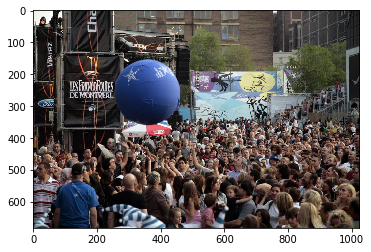

In [10]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

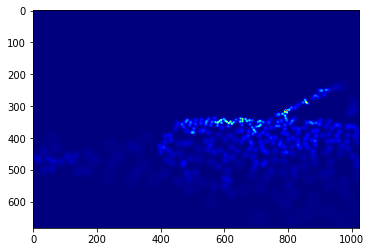

In [11]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [12]:
np.sum(groundtruth)# don't mind this slight variation 

308.87024

In [10]:
len(mat['image_info'][0,0][0,0][0])

311

In [13]:
#now generate the ShanghaiB's ground truth
#path_sets = [part_B_train,part_B_test]

In [14]:
#img_paths = []
#for path in path_sets:
#    for img_path in glob.glob(os.path.join(path, '*.jpg')):
#        img_paths.append(img_path)

In [15]:
#for img_path in img_paths:
#    if os.path.isfile(img_path.replace('.jpg','.h5').replace('images','ground_truth')):
#        break
#    print img_path
#    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
#    img= plt.imread(img_path)
#    k = np.zeros((img.shape[0],img.shape[1]))
#    gt = mat["image_info"][0,0][0,0][0]
#    for i in range(0,len(gt)):
#        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
#            k[int(gt[i][1]),int(gt[i][0])]=1
#    k = gaussian_filter(k,15)
#    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
#            hf['density'] = k